In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

import pandas as pd
import numpy as np 

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (20, 20)

## "Neutral" Gnocchi depends on GC content at Mb scales, but not at kb scales


In [2]:
def get_gnocchi_and_GC_content(window_size):
  chen_data_directory = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
  chen_file_stem = f'Supplementary_Data_2' # chen scores for 1kb windows
  filename = f'{chen_data_directory}/{chen_file_stem}.GC_content_{window_size}.bed'  
  df = pd.read_csv(
    filename, 
    sep='\t',
  )
  return df

get_gnocchi_and_GC_content(1000)

,window_chrom,window_start,window_end,chen_chrom,chen_start,chen_end,chen_score,window_GC_content
0,chr1,782999,784000,chr1,783000,784000,1.355101,0.319680
1,chr1,783999,785000,chr1,784000,785000,1.745145,0.314685
2,chr1,785999,787000,chr1,786000,787000,4.388539,0.365634
3,chr1,786999,788000,chr1,787000,788000,1.893217,0.375624
4,chr1,791999,793000,chr1,792000,793000,2.075487,0.390609
...,...,...,...,...,...,...,...,...
1984895,chr9,138137999,138139000,chr9,138138000,138139000,3.777362,0.557443
1984896,chr9,138138999,138140000,chr9,138139000,138140000,4.693755,0.603397
1984897,chr9,138157999,138159000,chr9,138158000,138159000,1.646564,0.406593
1984898,chr9,138209999,138211000,chr9,138210000,138211000,2.748850,0.479520


In [3]:
def correlate_gnocchi_with_GC_content_core(df, window_size, predicted=None):
  GC = np.array(df['window_GC_content'])
  gnocchi = np.array(df['chen_score'])

  if predicted:
    x, y_mean, y_std = predicted

  plt.figure(figsize=(10, 10))
  hb = plt.hexbin(GC, gnocchi, gridsize=50, cmap='inferno')
  cb = plt.colorbar(hb)
  cb.set_label('number of 1kb windows')
  plt.xlabel(f'GC content (averaged over {window_size/1000}kb)')
  plt.ylabel('gnocchi (per kb)')
  plt.xlim(min(GC), max(GC))
  plt.ylim(-10, 10)
  if predicted:
    plt.plot(x, y_mean, color='red')
    # plt.plot(x, y_std, color='yellow')
  plt.show()

  if predicted:
    gnocchi_corrected = np.array(df['corrected_chen_score'])

    plt.figure(figsize=(10, 10))
    hb = plt.hexbin(GC, gnocchi_corrected, gridsize=50, cmap='inferno')
    cb = plt.colorbar(hb)
    cb.set_label('number of 1kb windows')
    plt.xlabel(f'GC content (averaged over {window_size/1000}kb)')
    plt.ylabel('corrected gnocchi (per kb)')
    plt.xlim(min(GC), max(GC))
    plt.ylim(-10, 10)
    plt.show()

def correlate_gnocchi_with_GC_content(window_size):
  df = get_gnocchi_and_GC_content(window_size)
  correlate_gnocchi_with_GC_content_core(df, window_size) 


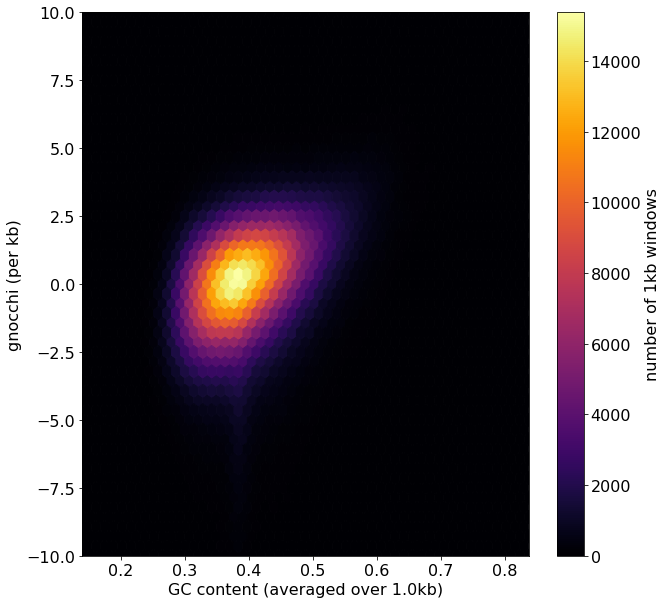

In [4]:
correlate_gnocchi_with_GC_content(window_size=1000) 

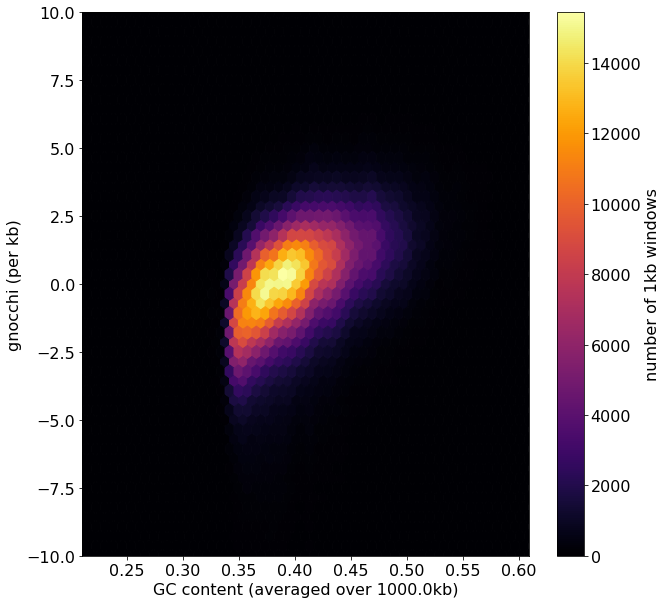

In [5]:
correlate_gnocchi_with_GC_content(window_size=1000000) 

## Correct Gnocchi by regressing out GC content

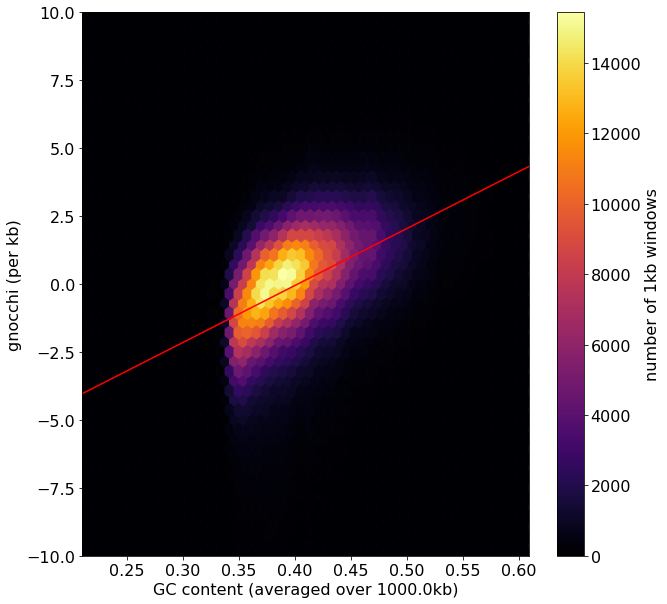

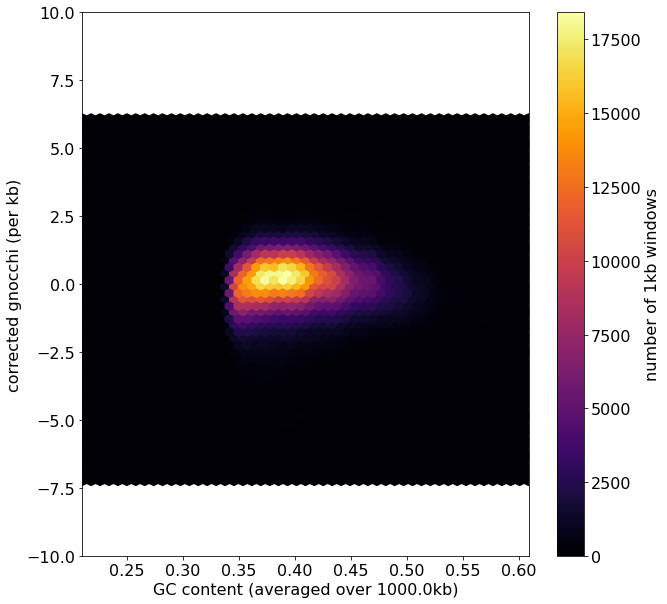

,chen_chrom,chen_start,chen_end,chen_score,corrected_chen_score
0,chr1,783000,784000,1.355101,0.103366
1,chr1,784000,785000,1.745145,0.316325
2,chr1,786000,787000,4.388539,1.772815
3,chr1,787000,788000,1.893217,0.388019
4,chr1,792000,793000,2.075487,0.470584
...,...,...,...,...,...
1984895,chr9,138138000,138139000,3.777362,1.625425
1984896,chr9,138139000,138140000,4.693755,2.132221
1984897,chr9,138158000,138159000,1.646564,0.452027
1984898,chr9,138210000,138211000,2.748850,1.092371


In [12]:
# Note that regression will capture the dependence of neutral gnocchi on GC content, 
# as that is where most of the data lie. 

def correct_gnocchi_for_GC_content(window_size, plot=True):
  df = get_gnocchi_and_GC_content(window_size)

  GC = np.array(df['window_GC_content'])
  gnocchi = np.array(df['chen_score'])

  X = GC.reshape(-1, 1)
  y = gnocchi

  model_mean = LinearRegression()
  model_mean.fit(X, y)
  predicted_mean = model_mean.predict(X)

  residuals = y - predicted_mean

  # Predict the variance using the squared residuals
  model_variance = LinearRegression()
  model_variance.fit(X, residuals**2)
  predicted_variance = model_variance.predict(X)

  df['corrected_chen_score'] = (y - predicted_mean) / np.sqrt(predicted_variance)

  if plot: 
    x = np.linspace(0, 1, 100).reshape(-1, 1)
    y_mean = model_mean.predict(x)
    y_std = np.sqrt(model_variance.predict(x))

    correlate_gnocchi_with_GC_content_core(df, window_size, predicted=(x, y_mean, y_std)) 

  chen_data_directory = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
  chen_file_stem = f'Supplementary_Data_2' # chen scores for 1kb windows
  filename = f'{chen_data_directory}/{chen_file_stem}.GC_content_{window_size}.corrected.bed'  
  df = df[['chen_chrom', 'chen_start', 'chen_end', 'chen_score', 'corrected_chen_score']]
  df.to_csv( 
    filename, 
    sep='\t',
    index=False,
  )

  return df
  
correct_gnocchi_for_GC_content(window_size=1000000)

In [14]:
for window_size in tqdm([1000, 10000, 100000, 1000000]):
  correct_gnocchi_for_GC_content(window_size, plot=False)

100%|████████████████████████████████████████████| 4/4 [00:31<00:00,  7.83s/it]


## Spatial profile of corrected Gnocchi

chr1:183400000-201000000


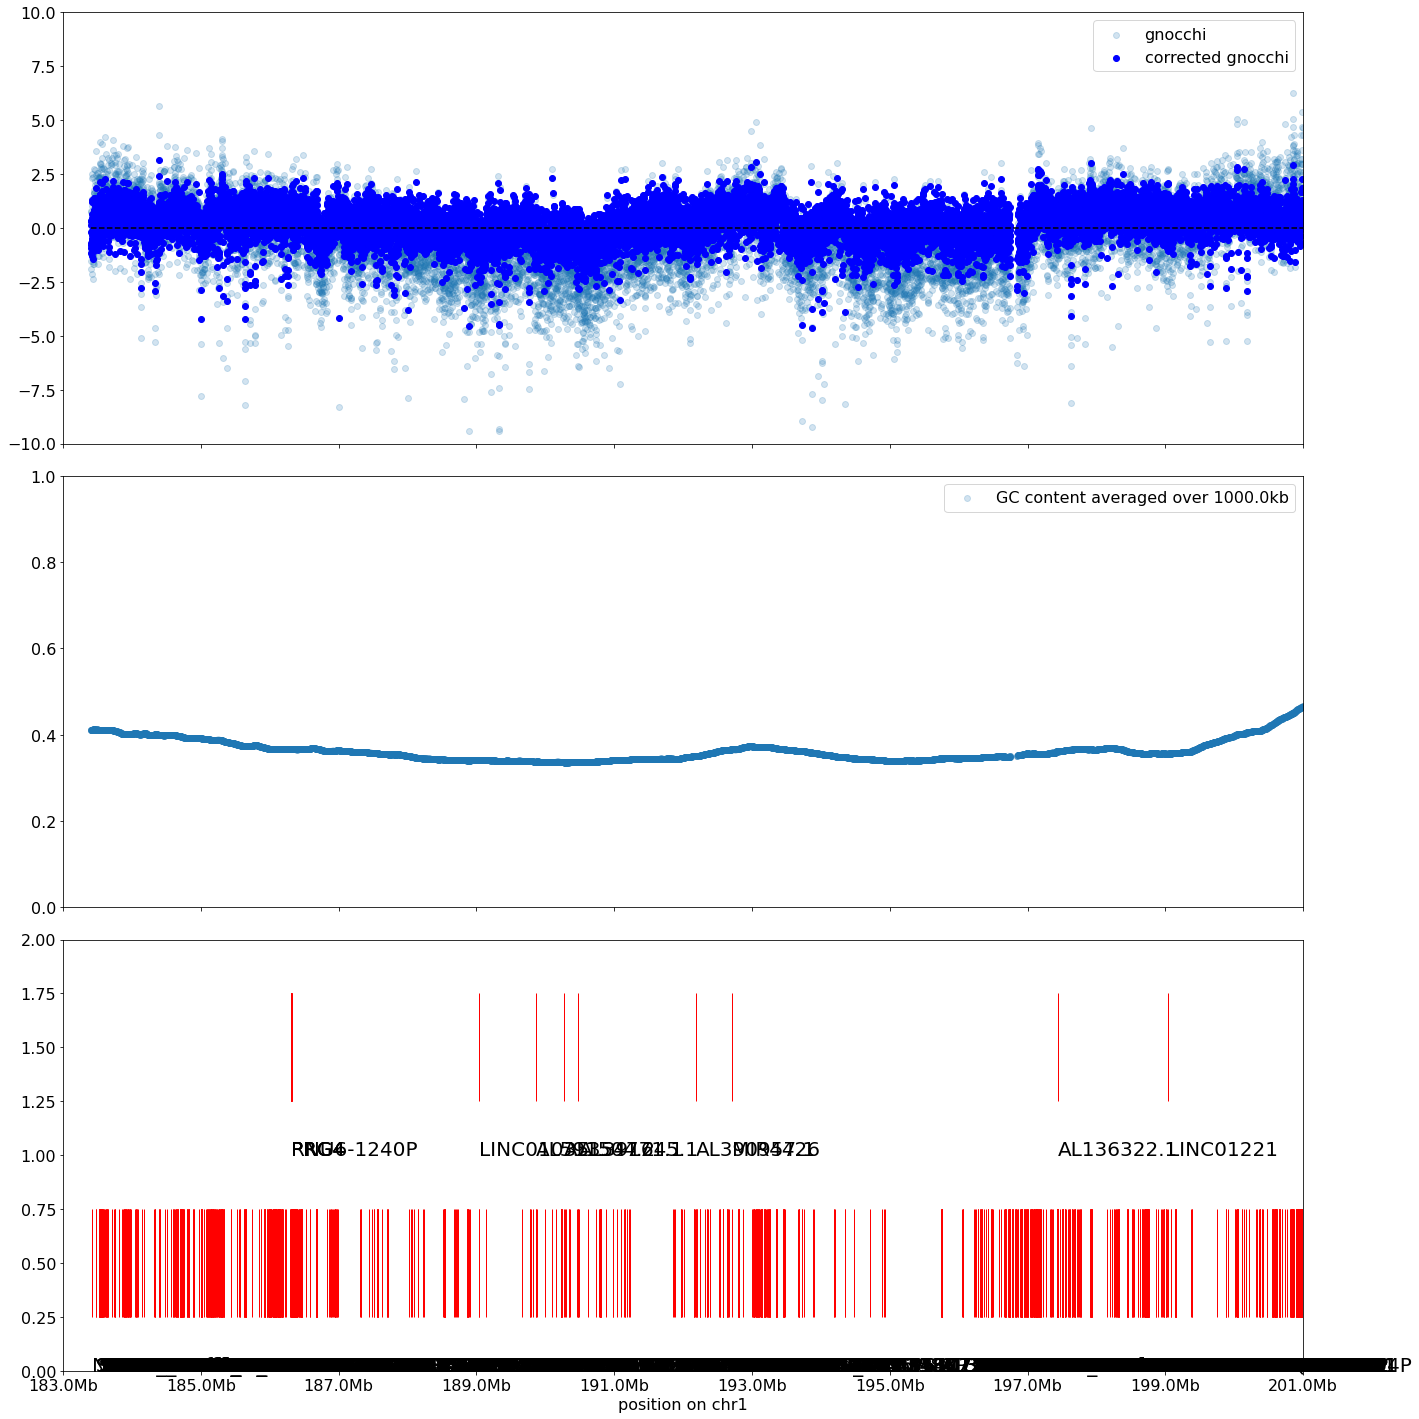

In [7]:
import matplotlib.patches as patches
from matplotlib.pyplot import plot
from intervals2layers import intervals2layers

def plot_gnocchi(df, ax):
  x = np.array(df['chen_center'])
  y = np.array(df['chen_score'])
  y_corrected = np.array(df['corrected_chen_score'])

  ax.scatter(x, y, label='gnocchi', alpha=0.2)
  ax.scatter(x, y_corrected, color='blue', label='corrected gnocchi')

  ax.set_xticks([])
  ax.set_ylim(-10, 10)
  ax.legend()

def plot_GC_content(df, ax, window_size):
  x = np.array(df['chen_center'])
  y = np.array(df['window_GC_content'])

  ax.scatter(x, y, label=f'GC content averaged over {window_size/1000}kb', alpha=0.2)

  ax.set_xticks([])
  ax.set_ylim(0, 1)
  ax.legend()

def plot_exon_pileup(ax, chromosome, start, end):
  df = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/genes/grch38/canonical-exons.sorted.bed', 
    sep='\t', 
    header=None,
    names=['exon_chrom', 'exon_start', 'exon_end', 'gene_name', 'exon_rank', 'strand', 'exon_is_constitutive', 'gene_biotype']
  )

  df = df[df['exon_chrom'] == chromosome] 
  df = df[(df['exon_start'] > start) & (df['exon_end'] < end)]

  intervals = df[['exon_start', 'exon_end', 'gene_name']].to_records(index=False).tolist()
  layers = intervals2layers(intervals)

  for i, layer in enumerate(layers):
    exon_starts, exon_ends, gene_names = zip(*layer)
    for exon_start, exon_end, gene_name in zip(exon_starts, exon_ends, gene_names):
      rect = patches.Rectangle(
        xy=(exon_start, i+0.25), 
        width=exon_end-exon_start, 
        height=0.5, 
        linewidth=1, 
        edgecolor='r', 
        facecolor='r'
      )
      ax.add_patch(rect)
      ax.text(exon_start, i, gene_name, fontsize=20)
  ax.set_ylim(0, len(layers))

def round_to_nearest_million(x):
  multiple = x / 1e6
  multiple = round(multiple)
  return int(multiple * 1e6)

def plot_gnocchi_GC_exons(chromosome, start, end, window_size, tick_interval=2e6):
  print(f'{chromosome}:{start}-{end}') 

  df = correct_gnocchi_for_GC_content(window_size, plot=False)

  df = df[df['window_chrom'] == chromosome] 
  df['chen_center'] = (df['chen_start'] + df['chen_end'])/2
  df = df[
    (df['chen_center'] > start) &
    (df['chen_center'] < end)
  ]

  fig, axs = plt.subplots(3, figsize=(20, 20), sharex=True)

  plot_gnocchi(df, axs[0])
  axs[0].plot([start, end], [0, 0], color='black', linestyle='--')

  plot_GC_content(df, axs[1], window_size)

  plot_exon_pileup(axs[2], chromosome, start, end)
  axs[2].set_xlim(start, end)
  axs[2].set_xlabel(f'position on {chromosome}')

  smallest_tick = round_to_nearest_million(start) 
  largest_tick = round_to_nearest_million(end)
  xticks = np.arange(smallest_tick, largest_tick+1, tick_interval)
  axs[2].set_xticks(xticks)
  formatter = ticker.FuncFormatter(lambda x, pos: f'{x/1e6}Mb')
  axs[2].xaxis.set_major_formatter(formatter)

  plt.tight_layout()
  plt.show()

plot_gnocchi_GC_exons(chromosome='chr1', start=183400000, end=201000000, window_size=1000000)

chr2:222199887-222298998


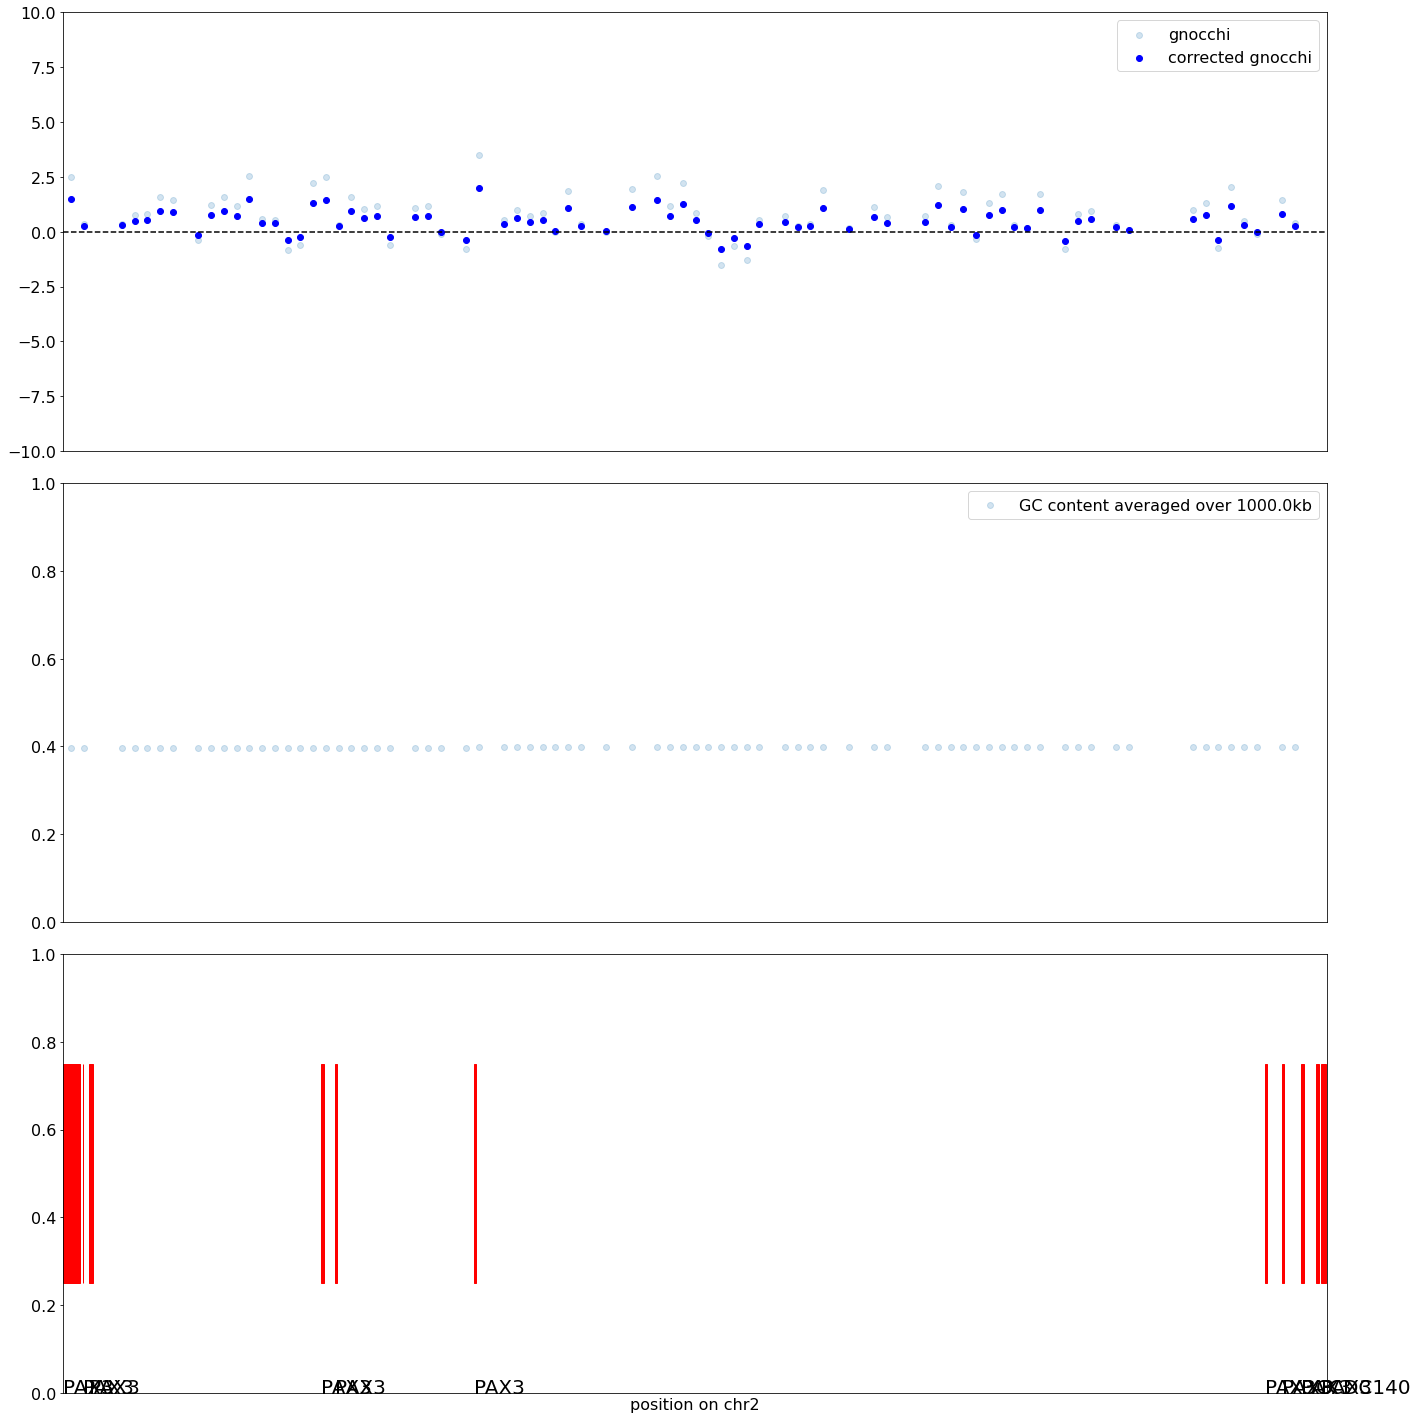

In [8]:
# PAX3 is a critical gene 
plot_gnocchi_GC_exons(chromosome='chr2', start=222199887, end=222298998, window_size=1000000)